In [2]:
import sys
import warnings
warnings.filterwarnings("ignore")
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import palantir
import matplotlib.pyplot as plt
sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout
## fix palantir breaking down some plots
import seaborn
seaborn.reset_orig()
%matplotlib inline

sc.set_figure_params()
scf.set_figure_pubready()

In [3]:
counts = palantir.io.from_csv('https://github.com/dpeerlab/Palantir/raw/master/data/marrow_sample_scseq_counts.csv.gz')
norm_df = sc.pp.normalize_per_cell(counts,copy=True)
norm_df = palantir.preprocess.log_transform(norm_df)

In [4]:
adata=sc.AnnData(norm_df)
sc.pp.highly_variable_genes(adata, n_top_genes=1500, flavor='cell_ranger')
sc.pp.pca(adata)
pca_projections = pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [5]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections)
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=4)
# generate neighbor draph in multiscale diffusion space
adata.obsm["X_palantir"]=ms_data.values
sc.pp.neighbors(adata,n_neighbors=30,use_rep="X_palantir")
# draw ForceAtlas2 embedding using 2 first PCs as initial positions
adata.obsm["X_pca2d"]=adata.obsm["X_pca"][:,:2]
sc.tl.draw_graph(adata,init_pos='X_pca2d')

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:25)


In [6]:
scf.tl.tree(adata,method="ppt",Nodes=200,use_rep="palantir",
            device="cpu",seed=1,ppt_lambda=100,ppt_sigma=0.025,ppt_nsteps=200)

inferring a principal tree inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.025, lambda = 100, metric = euclidean
    fitting:  71%|███████   | 142/200 [00:15<00:06,  8.90it/s]
    converged
    finished (0:00:16) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


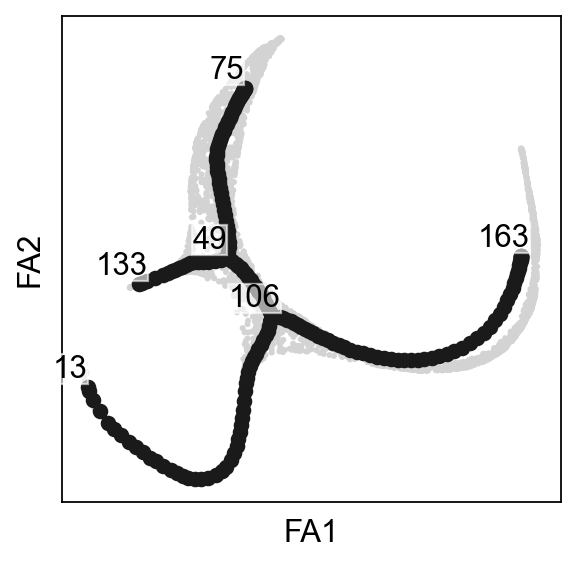

In [7]:
scf.pl.graph(adata)

In [8]:
scf.tl.root(adata,163)
scf.tl.pseudotime(adata,n_jobs=40,n_map=100,seed=42)

node 163 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    mappings: 100%|██████████| 100/100 [00:32<00:00,  3.07it/s]
    finished (0:00:35) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


In [9]:
scf.tl.test_association(adata,n_jobs=40)
scf.tl.fit(adata,n_jobs=40)

test features for association with the trajectory
    single mapping : 100%|██████████| 16106/16106 [02:41<00:00, 99.74it/s] 
    found 3387 significant features (0:02:41) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.
fit features associated with the trajectory
    single mapping : 100%|██████████| 3387/3387 [01:47<00:00, 31.43it/s]
    finished (adata subsetted to keep only fitted features!) (0:01:52) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


In [11]:
scf.tl.rename_milestones(adata,["bifA","Ery","DC","Root","BifB","Mono"])
scf.tl.test_fork(adata,root_milestone="Root",milestones=["DC","Mono"],n_jobs=20,rescale=True)
scf.tl.branch_specific(adata,root_milestone="Root",milestones=["DC","Mono"],effect=1.7)


testing fork
    single mapping
    Differential expression: 100%|██████████| 3387/3387 [01:01<00:00, 55.41it/s]
    test for upregulation for each leave vs root
    upreg Mono: 100%|██████████| 789/789 [00:01<00:00, 634.13it/s]
    finished (0:01:05) --> added 
    .uns['Root->DC<>Mono']['fork'], DataFrame with fork test results.
    branch specific features: DC: 65, Mono: 23
    finished --> updated 
    .uns['Root->DC<>Mono']['fork'], DataFrame updated with additionnal 'branch' column.


AttributeError: 'DataFrame' object has no attribute 'module'

... storing 'seg' as categorical


<AxesSubplot:title={'center':'milestones'}, xlabel='FA1', ylabel='FA2'>

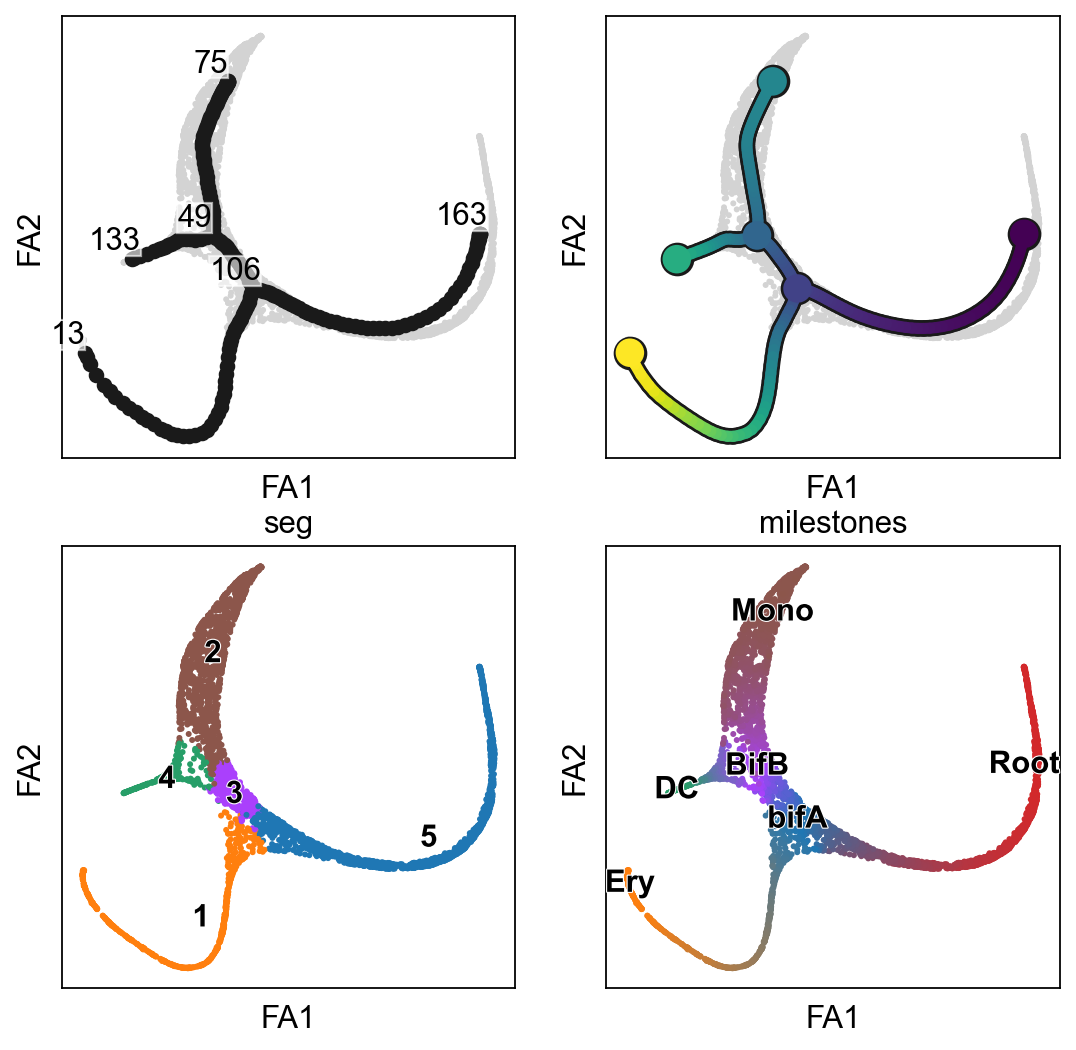

In [13]:
sc.set_figure_params()
fig, axs=plt.subplots(2,2,figsize=(8,8))
axs=axs.ravel()
scf.pl.graph(adata,basis="draw_graph_fa",show=False,ax=axs[0])
scf.pl.trajectory(adata,basis="draw_graph_fa",show=False,ax=axs[1])
sc.pl.draw_graph(adata,color=["seg"],legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True)
scf.pl.milestones(adata,ax=axs[3],show=False,annotate=True)


    prefork activation: 100%|██████████| 88/88 [00:00<00:00, 391.22it/s]


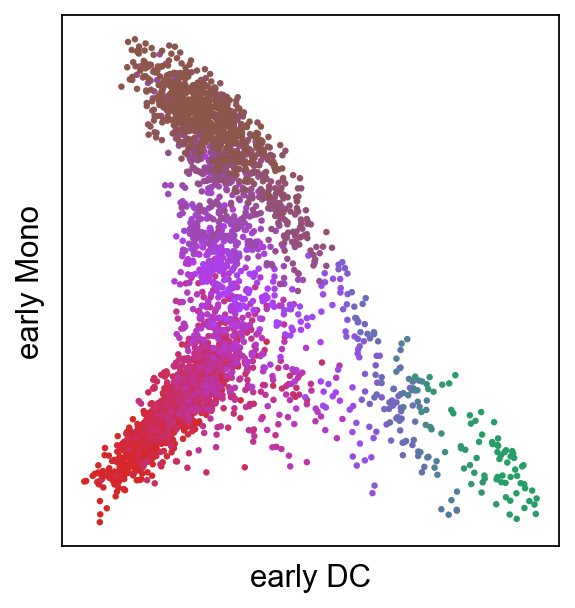

In [14]:
scf.tl.activation_lm(adata,root_milestone="Root",milestones=["DC","Mono"],n_jobs=20)
scf.pl.modules(adata,root_milestone="Root",milestones=["DC","Mono"],
               smooth=True,module="early")

In [15]:
scf.tl.slide_cells(adata,root_milestone="Root",milestones=["DC","Mono"],win=400)
scf.tl.slide_cors(adata,root_milestone="Root",milestones=["DC","Mono"])

In [16]:
scf.tl.synchro_path(adata,root_milestone="Root",milestones=["DC","Mono"],w=100,n_map=50,n_jobs=20)

    multi mapping permutations: 100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


In [17]:
adata.write("adata_final.h5ad")

/home/lfaure/miniconda3/envs/rapids-22.06/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/lfaure/miniconda3/envs/rapids-22.06/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/lfaure/miniconda3/envs/rapids-22.06/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/lfaure/miniconda3/envs/rapids-22.06/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWa